In [34]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set()
%matplotlib inline

# Seller profitability by order value

In [2]:
sellers = pd.read_csv('./brazilian-ecommerce/olist_sellers_dataset.csv', index_col=0)
order_items = pd.read_csv('./brazilian-ecommerce/olist_order_items_dataset.csv')
orders = pd.read_csv('./brazilian-ecommerce/olist_orders_dataset.csv')

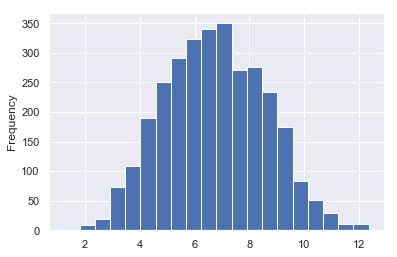

In [71]:
sellers.merge(order_items.groupby('seller_id')[['price', 'freight_value']].sum(),
              'left', left_index=True, right_index=True)\
        .sort_values(by='price', ascending=False)\
        .loc[:,'price']\
        .apply(np.log)\
        .plot.hist(bins=20);

Merchant revenue approx. follows a lognormal distribution

# Seller popularity by order volume

In [26]:
order_items['seller_id'].value_counts()

6560211a19b47992c3666cc44a7e94c0    2033
4a3ca9315b744ce9f8e9374361493884    1987
1f50f920176fa81dab994f9023523100    1931
cc419e0650a3c5ba77189a1882b7556a    1775
da8622b14eb17ae2831f4ac5b9dab84a    1551
955fee9216a65b617aa5c0531780ce60    1499
1025f0e2d44d7041d6cf58b6550e0bfa    1428
7c67e1448b00f6e969d365cea6b010ab    1364
ea8482cd71df3c1969d7b9473ff13abc    1203
7a67c85e85bb2ce8582c35f2203ad736    1171
4869f7a5dfa277a7dca6462dcf3b52b2    1156
3d871de0142ce09b7081e2b9d1733cb1    1147
8b321bb669392f5163d04c59e235e066    1018
cca3071e3e9bb7d12640c9fbe2301306     830
620c87c171fb2a6dd6e8bb4dec959fc6     798
a1043bafd471dff536d0c462352beb48     770
e9779976487b77c6d4ac45f75ec7afe9     750
f8db351d8c4c4c22c6835c19a46f01b0     724
d2374cbcbb3ca4ab1086534108cc3ab7     631
391fc6631aebcf3004804e51b40bcf1e     613
fa1c13f2614d7b5c4749cbc52fecda94     586
7d13fca15225358621be4086e1eb0964     578
128639473a139ac0f3e5f5ade55873a5     560
1835b56ce799e6a4dc4eddc053f04066     558
46dc3b2cc0980fb8

In [24]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
order_id               112650 non-null object
order_item_id          112650 non-null int64
product_id             112650 non-null object
seller_id              112650 non-null object
shipping_limit_date    112650 non-null object
price                  112650 non-null float64
freight_value          112650 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


# Map to Lat Long for Tableau

In [54]:
geoloc = pd.read_csv('./brazilian-ecommerce/olist_geolocation_dataset.csv', usecols=[0,1,2])
geoloc['geolocation_zip_code_prefix'] = geoloc['geolocation_zip_code_prefix'].astype(int)

In [66]:
geoloc[geoloc.geolocation_zip_code_prefix == 13023].mean()

geolocation_zip_code_prefix    13023.000000
geolocation_lat                  -22.893848
geolocation_lng                  -47.061337
dtype: float64

In [46]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3095 entries, 3442f8959a84dea7ee197c632cb2df15 to 9e25199f6ef7e7c347120ff175652c3b
Data columns (total 6 columns):
seller_zip_code_prefix    3095 non-null int64
seller_city               3095 non-null object
seller_state              3095 non-null object
order_vol                 3095 non-null int64
price                     3095 non-null float64
freight_value             3095 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 249.3+ KB


In [30]:
sellers = sellers.set_index('seller_id')
sellers['order_vol'] = order_items['seller_id'].value_counts()

In [41]:
sellers = sellers.merge(order_items.groupby('seller_id')[['price', 'freight_value']].sum(),
                        'left', left_index=True, right_index=True)

In [68]:
pd.merge(sellers.reset_index(), geoloc.groupby('geolocation_zip_code_prefix').mean(),
         how='left', left_on='seller_zip_code_prefix', right_index=True).to_csv('merchant_value_coords.csv')

# TODO: build targeting models using features created from merchant behavior

Dependent variables: 
* Churn
  * Hazard model with age of merchant in months as hazard dependent variable
  * Features to use are revenue, biz segment, lead_type, lead_behavior_profile, biz type, review rating, maybe city?
* Value/Revenue
  * Linear Regression, with log transform on mean monthly revenue
  * Features to use are category, num_prods, price, payment terms, reviews, maybe city?

## Churn

In [5]:
sellers = pd.read_csv('./brazilian-ecommerce/olist_sellers_dataset.csv', index_col=0)
order_items = pd.read_csv('./brazilian-ecommerce/olist_order_items_dataset.csv')
orders = pd.read_csv('./brazilian-ecommerce/olist_orders_dataset.csv')
prods = pd.read_csv('./brazilian-ecommerce/olist_products_dataset.csv')
cats = pd.read_csv('./brazilian-ecommerce/product_category_name_translation.csv')
reviews = pd.read_csv('./brazilian-ecommerce/olist_order_reviews_dataset.csv')
payments = pd.read_csv('./brazilian-ecommerce/olist_order_payments_dataset.csv')

In [127]:
order_items = order_items.merge(prods.merge(cats, how='left', on='product_category_name')\
                                     .loc[:,['product_id', 'product_category_name_english']],
                                how='left', on='product_id')\
                         .merge(reviews[['order_id', 'review_score']], how='left', on='order_id')\
                         .merge(payments[['order_id', 'payment_type', 'payment_installments']],
                                how='left', on='order_id')

In [128]:
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)
order_items = order_items.merge(orders[['order_id', 'order_purchase_timestamp']], how='left', on='order_id')

In [131]:
order_items.drop(columns=['order_id', 'order_item_id', 'product_id', 'shipping_limit_date'], inplace=True)

In [11]:
# order_items.to_csv('merchant_churn.csv')

In [133]:
order_items.isna().sum()

seller_id                           0
price                               0
freight_value                       0
product_category_name_english    1734
review_score                        0
payment_type                        3
payment_installments                3
order_purchase_timestamp            0
dtype: int64

In [134]:
order_items.product_category_name_english.fillna('NA_category', inplace=True)

In [135]:
temp = order_items.groupby('seller_id').agg({'price': lambda x: np.mean(np.log(x)),
                                             'freight_value': np.median,
                                             'product_category_name_english': lambda x: list(set(x)),
                                             'review_score': np.mean,
                                             'payment_type': lambda x: list(set(x)),
                                             'payment_installments': np.mean,
                                             'order_purchase_timestamp': [np.max, np.min]})

In [136]:
temp.columns = ['mean_log_price', 'mean_review_score', 'last_order_timestamp', 'first_order_timestamp',
                'payment_type', 'product_category', 'mean_installments', 'median_freight']

In [138]:
# convert to dummies
payment_dummies = pd.get_dummies(temp.payment_type.apply(pd.Series).stack()).sum(level=0)\
                    .rename(columns=lambda x: 'payment_type_'+x)

In [139]:
# take top 10 categories, concat the rest as 'others'
top_categories = temp.product_category.apply(pd.Series).stack().value_counts()[:10].index.tolist()
category_dummies = pd.get_dummies(temp.product_category.apply(pd.Series).stack()).sum(level=0)
category_dummies['others'] = category_dummies.loc[:,~category_dummies.columns.isin(top_categories)].max(axis=1)
category_dummies = category_dummies[top_categories + ['others']]

In [140]:
temp =  temp.merge(payment_dummies, how='inner', left_index=True, right_index=True)\
            .merge(category_dummies, how='inner', left_index=True, right_index=True)\
            .drop(columns=['payment_type', 'product_category'])

In [141]:
temp['last_order_timestamp'] = temp['last_order_timestamp'].dt.date
temp['first_order_timestamp'] = temp['first_order_timestamp'].dt.date

In [143]:
temp.to_csv('merchant_preprocessed.csv')

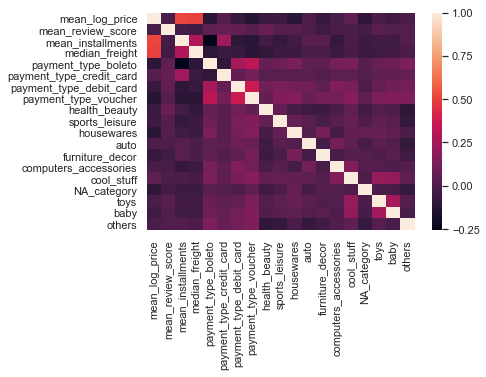

In [149]:
sns.heatmap(temp.corr());

Read in predicted churn rates from R survival's Weibull AFT model

In [2]:
churn = pd.read_csv('./predicted_churn_weeks.csv', index_col=0)

In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2950 entries, 0015a82c2db000af6aaaf3ae2ecb0532 to fffd5413c0700ac820c7069d66d98c89
Data columns (total 3 columns):
fitted         2950 non-null float64
quantile_10    2950 non-null float64
quantile_90    2950 non-null float64
dtypes: float64(3)
memory usage: 92.2+ KB


## Expected revenue

$$CLV=\sum_{t=0}^T{\frac{mr^t}{(1+d)^t}} - AC$$ i.e. CLV model 2

**Assumptions:**
* Annual discount rate of 20% (aggressive cost of capital)
* Profit to platform is 10% of merchant's revenue
* Use Weekly values

In [6]:
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)
order_items = order_items.merge(orders[['order_id', 'order_purchase_timestamp']], how='left', on='order_id')

In [9]:
temp = order_items.groupby('seller_id').agg({'price': lambda x: np.sum(np.log(x)),
                                             'order_purchase_timestamp': lambda x: np.max(x) - np.min(x)})

In [10]:
temp.columns = ['total_log_revenue', 'timespan']

In [25]:
temp['timespan'] = temp.timespan.dt.days / 7 + 1
temp['avg_weekly_revenue'] = temp.total_log_revenue / temp.timespan

In [36]:
temp.head()

,total_log_revenue,timespan,avg_weekly_revenue
seller_id,,,
0015a82c2db000af6aaaf3ae2ecb0532,20.390471,4.000000,5.097618
001cca7ae9ae17fb1caed9dfb1094831,1109.547759,75.714286,14.654404
001e6ad469a905060d959994f1b41e4f,5.521461,1.000000,5.521461
002100f778ceb8431b7a1020ff7ab48f,163.422841,31.000000,5.271705
003554e2dce176b5555353e4f3555ac8,4.787492,1.000000,4.787492


In [42]:
temp[~temp.index.isin(churn.index)].shape # 145 sellers dropped due to left-censorship

(145, 3)

In [45]:
clv = temp.merge(churn, how='inner', left_index=True, right_index=True)
clv.head()

,total_log_revenue,timespan,avg_weekly_revenue,fitted,quantile_10,quantile_90
seller_id,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,20.390471,4.000000,5.097618,16.426616,1.485884,40.023415
001cca7ae9ae17fb1caed9dfb1094831,1109.547759,75.714286,14.654404,578.037344,52.286867,1408.386729
001e6ad469a905060d959994f1b41e4f,5.521461,1.000000,5.521461,3.773009,0.341291,9.192928
002100f778ceb8431b7a1020ff7ab48f,163.422841,31.000000,5.271705,102.393612,9.262103,249.481813
003554e2dce176b5555353e4f3555ac8,4.787492,1.000000,4.787492,5.290580,0.478564,12.890486


In [52]:
# constants
annual_disc = 0.2
commission = 0.1

In [69]:
wkly_disc = (1+annual_disc)**(1/52)

In [86]:
clv['PV_factor'] = clv.fitted.apply(lambda x: sum((1/wkly_disc)**t for t in range(int(x)+1)))
clv['CLV'] = clv.avg_weekly_revenue * commission * clv.PV_factor 

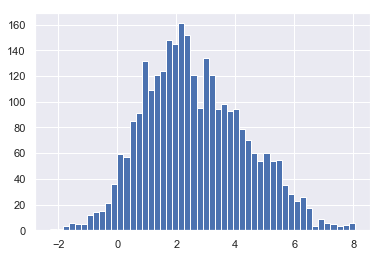

In [97]:
clv.CLV.apply(np.log).hist(bins=50); # log distribution is preserved

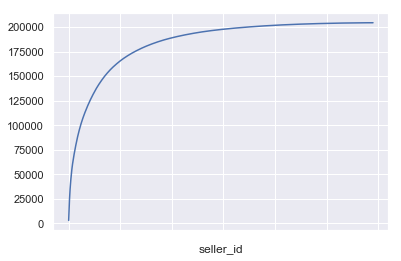

In [99]:
# cumulative value plot
clv.sort_values(by='CLV', ascending=False).CLV.cumsum().plot.line();